# Лінійна регресія. Престиж професій

Курс: Математичне моделювання в R

---

::: {.callout-important}
# Перевірити матеріали лекції!!! 

Розділ про мультиколінеарність та вибір найкращої моделі.
:::

In [ ]:
# install.packages("carData")
# install.packages("corrplot")
# install.packages("car")
# install.packages("modelr")
# install.packages("lmtest")
# install.packages("leaps")

In [1]:
Sys.setlocale("LC_CTYPE", "ukrainian")
options(warn = -1)

[1] "Ukrainian_Ukraine.1251"

## Dataset overview

У даному навчальному матеріалі використано класичний приклад даних з інформацією про престижність професій у Канаді 1971 року. Джерело: `carData::Prestige`.

In [2]:
library(carData)
data <- carData::Prestige
head(data)

,education,income,women,prestige,census,type
,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>
gov.administrators,13.11,12351,11.16,68.8,1113,prof
general.managers,12.26,25879,4.02,69.1,1130,prof
accountants,12.77,9271,15.70,63.4,1171,prof
purchasing.officers,11.42,8865,9.11,56.8,1175,prof
chemists,14.62,8403,11.68,73.5,2111,prof
physicists,15.64,11030,5.13,77.6,2113,prof


Переглянемо структуру даних:

In [3]:
str(data)

'data.frame':	102 obs. of  6 variables:
 $ education: num  13.1 12.3 12.8 11.4 14.6 ...
 $ income   : int  12351 25879 9271 8865 8403 11030 8258 14163 11377 11023 ...
 $ women    : num  11.16 4.02 15.7 9.11 11.68 ...
 $ prestige : num  68.8 69.1 63.4 56.8 73.5 77.6 72.6 78.1 73.1 68.8 ...
 $ census   : int  1113 1130 1171 1175 2111 2113 2133 2141 2143 2153 ...
 $ type     : Factor w/ 3 levels "bc","prof","wc": 2 2 2 2 2 2 2 2 2 2 ...


Значення показників вибірки:

- [x] `prestige` – престиж професії за Pineo-Porter score, на основі дослідження середини 1960-х. **It is target!!!**
- [x] `education` - середня кількість років освіти.
- [x] `income` – середній дохід респондентів, дол.
- [x] `women` – частка жінок у галузі
- [x] `census` – канадський код професії.
- [x] `type` – тип професії: bc, Blue Collar; prof, Professional, Managerial, and Technical; wc, White Collar.

Оглянемо описову статистику факторів:

In [4]:
summary(data)

   education          income          women           prestige    
 Min.   : 6.380   Min.   :  611   Min.   : 0.000   Min.   :14.80  
 1st Qu.: 8.445   1st Qu.: 4106   1st Qu.: 3.592   1st Qu.:35.23  
 Median :10.540   Median : 5930   Median :13.600   Median :43.60  
 Mean   :10.738   Mean   : 6798   Mean   :28.979   Mean   :46.83  
 3rd Qu.:12.648   3rd Qu.: 8187   3rd Qu.:52.203   3rd Qu.:59.27  
 Max.   :15.970   Max.   :25879   Max.   :97.510   Max.   :87.20  
     census       type   
 Min.   :1113   bc  :44  
 1st Qu.:3120   prof:31  
 Median :5135   wc  :23  
 Mean   :5402   NA's: 4  
 3rd Qu.:8312            
 Max.   :9517            

## Train/Test split

Розділимо загальну вибірку на 2 частини: * тренувальна, 70% вибірки, для побудови регресії; * тестова, 30% вибірки, для перевірки точності моделі.

In [4]:
set.seed(2024) #довільне число як точка "відправки" для генератора випадкових чисел

# Згенеруємо набір чисел від 1 до кількості спостережень у вибірці і відберемо випадквоим чином 70% із них
train_index <- sample(nrow(data), size = 0.7*nrow(data))

#Виведемо індекси (номери рядків) обраних для тренування даних
print(train_index)

 [1]  66  37  45  60  17  32  29  11  16  96  62  14  34  26  44  50  89  97   1
[20]  75  35  81  28  48  43  58  20  55  99   4   7  52  57  67  25  90  70  49
[39]  54  86  65   3  68  84   6  76   9  15  13  94  78  69  92  88   5  53  77
[58]  61  74  33  95  19  30  87  56 100  93 102  91  47  73


In [5]:
#Запишемо по номерах відібраних рядків тренувальний набір даних
train_data <- data[train_index, ]
head(train_data)

#Всі інші значення, що не увійшли в тренувальну вибірку запишемо у тестову
test_data <- data[-train_index, ]
head(test_data)

,education,income,women,prestige,census,type
,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>
elevator.operators,7.58,3582,30.08,20.1,6193,bc
bookkeepers,11.32,4348,68.24,49.4,4131,wc
telephone.operators,10.51,3161,96.14,38.1,4175,wc
cooks,7.74,3116,52.00,29.7,6121,bc
lawyers,15.77,19263,5.13,82.3,2343,prof
commercial.artists,11.09,6197,21.03,57.2,3314,prof


,education,income,women,prestige,census,type
,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>
general.managers,12.26,25879,4.02,69.1,1130,prof
architects,15.44,14163,2.69,78.1,2141,prof
mining.engineers,14.64,11023,0.94,68.8,2153,prof
draughtsmen,12.30,7059,7.83,60.0,2163,prof
librarians,14.15,6112,77.10,58.1,2351,prof
university.teachers,15.97,12480,19.59,84.6,2711,prof


## Short EDA (Exploratory data analysis)

### Correlation

Переглянемо наявність зв’язків між параметрами за допоомгою матриці попарних кореляцій. Дані на перетині рядків вказують на рівень кореляції між вибраними показниками.

Виключимо змінну type, оскільки вона не має числового представлення:

In [6]:
cor(train_data[ ,-6])

,education,income,women,prestige,census
education,1.00000000,0.6471281,0.01920266,0.8499264,-0.8210018
income,0.64712809,1.0000000,-0.42168807,0.7574192,-0.3482833
women,0.01920266,-0.4216881,1.00000000,-0.1376254,-0.2018702
prestige,0.84992635,0.7574192,-0.13762539,1.0000000,-0.6285128
census,-0.82100176,-0.3482833,-0.20187018,-0.6285128,1.0000000


Lets view correlation matrix with `corrplot()` function:

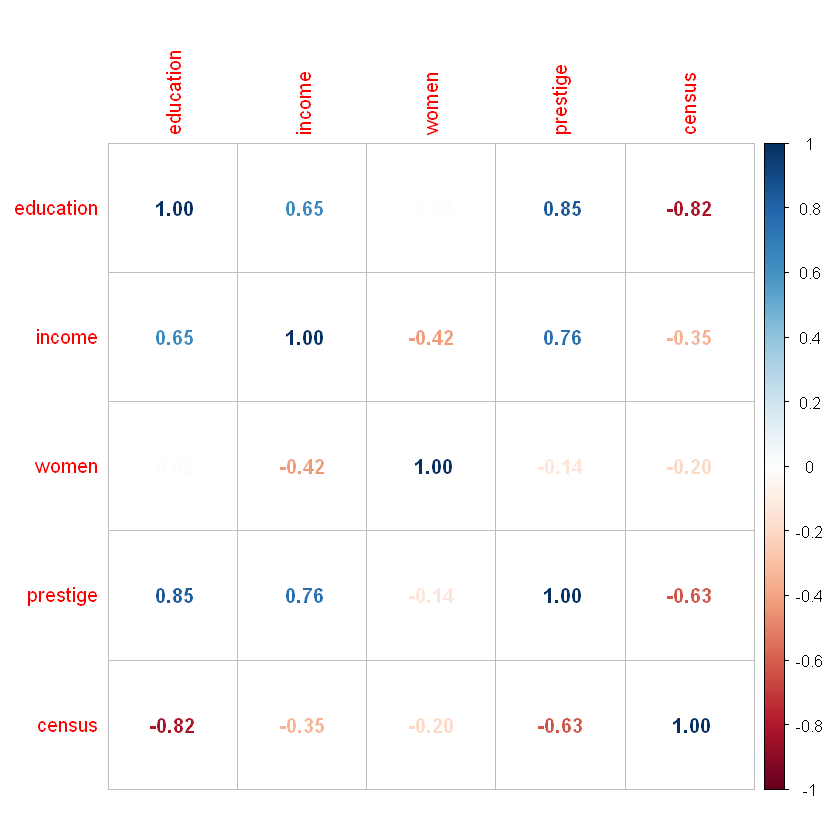

In [7]:
suppressMessages(library(corrplot))
corrplot(cor(train_data[,-6]) , method = "number") 

You can see hight correlation between `education ~ prestige`, `education ~ census`, `prestige ~ income`.

### Visual analysis

Lets check data distribution of some variables 

Target/Output variable `prestige`:

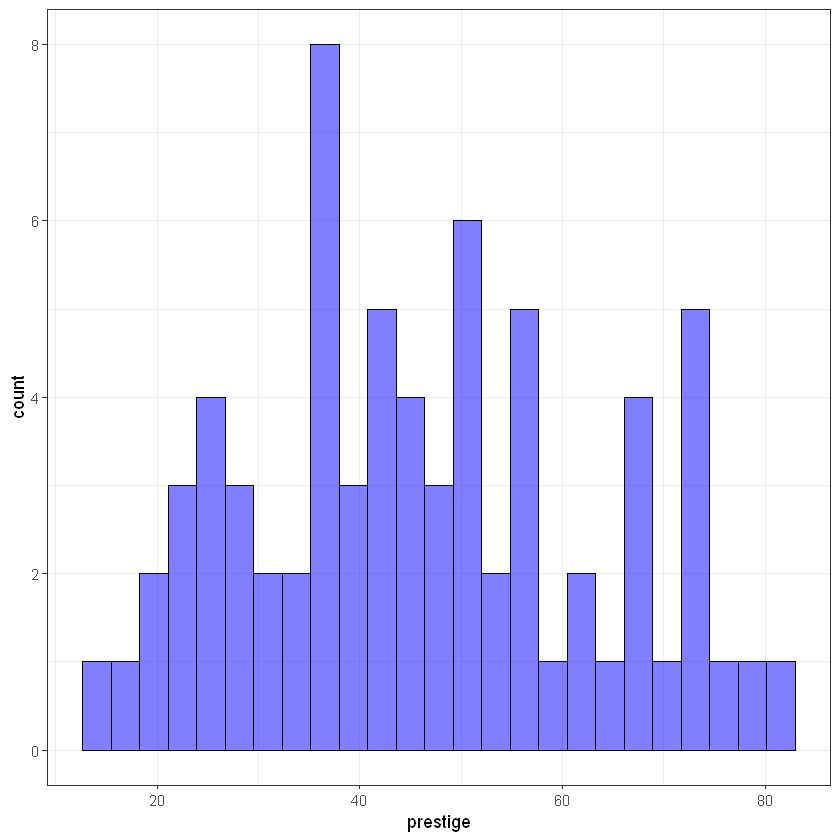

In [8]:
library(ggplot2)

ggplot(train_data, aes(prestige)) + 
    geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

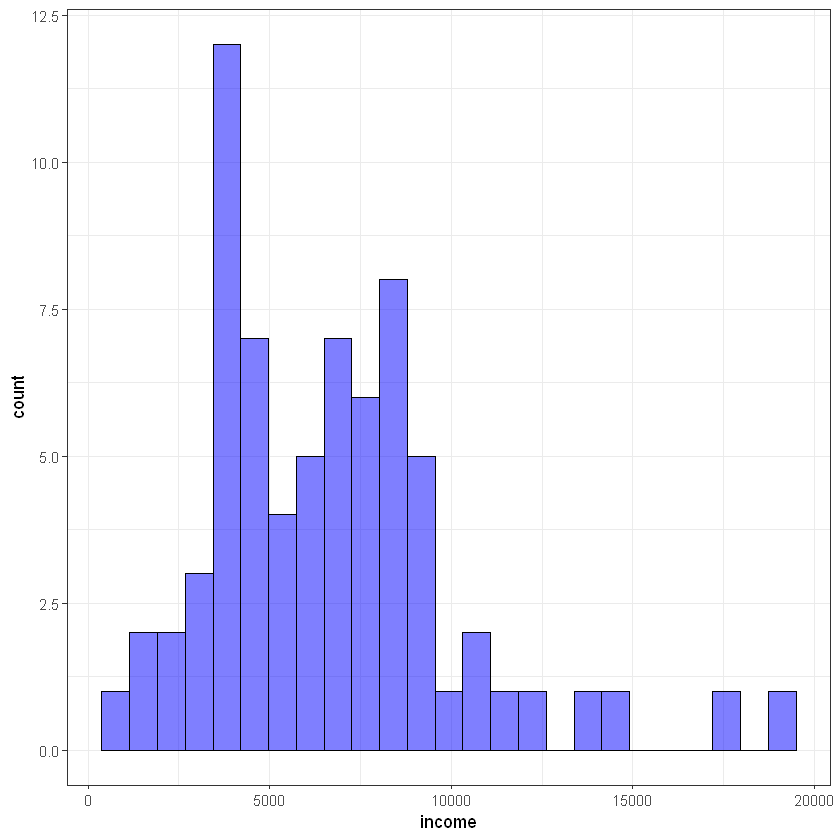

In [9]:
ggplot(train_data, aes(income)) + 
    geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

Input variable `income`:

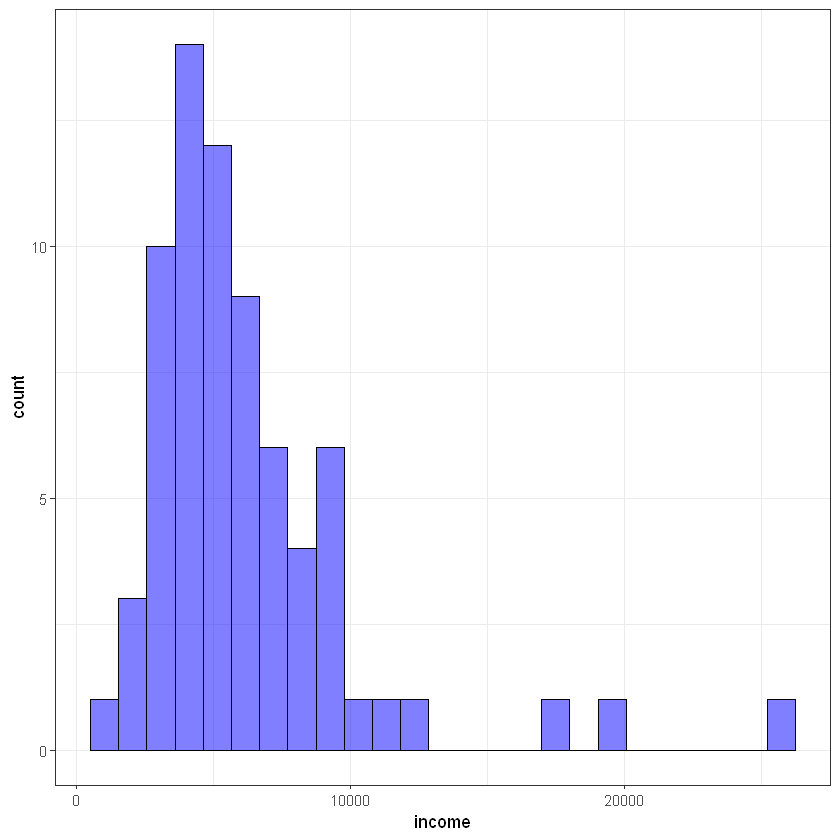

In [11]:
#ggplot(train_data, aes(log(income))) + 
ggplot(train_data, aes(income)) + 
    geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

Input variable `women`:

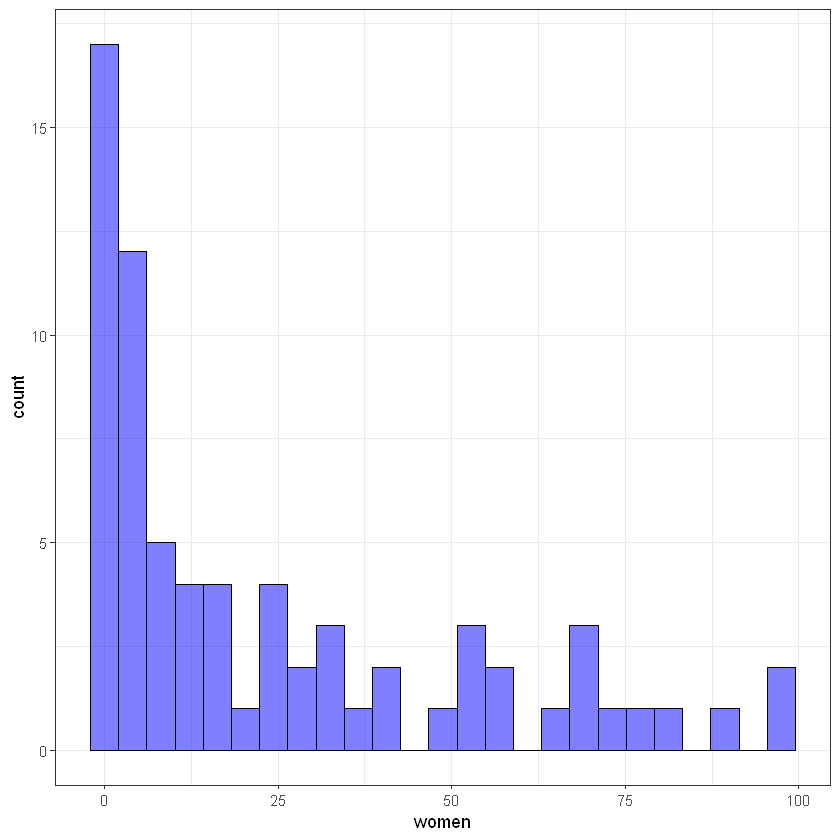

In [10]:
#ggplot(train_data, aes(log(women))) + 
ggplot(train_data, aes(women)) + 
    geom_histogram(bins = 25, alpha = 0.5, fill = 'blue', color='black')  + 
    theme_bw()

---

## Model building

Функція `lm()` використовується для побудови лінійної регресії.

Syntax: `lm(formula, data = train_data)`

`formula` дозволяє вказати на залежність між вхідними та вихідним параметром. У даному випадку `prestige` - залежна змінна (`Y`), а усі, що після знаку `~` - незалежні (`X`).


In [11]:
lm_mod <- lm(formula = prestige ~ income + education, data = train_data)

Для детальнішого опису параметрів побудованої моделі варто скористатися функцією `summary()`:

In [12]:
summary(lm_mod)


Call:
lm(formula = prestige ~ income + education, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.7525  -4.5878   0.4582   4.7086  17.3600 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.6264724  3.7225239  -1.511    0.135    
income       0.0017458  0.0003512   4.972 4.76e-06 ***
education    3.8021103  0.4408681   8.624 1.61e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.762 on 68 degrees of freedom
Multiple R-squared:  0.7964,	Adjusted R-squared:  0.7904 
F-statistic:   133 on 2 and 68 DF,  p-value: < 2.2e-16


---

### Demo task: generating final formula for regression

Спробуємо створити рядковий вигляд для побудованої регресії (шляхом звичайного “склеювання” рядків). Це завдання для закріплення знань з алгоритмічного програмування в R.

In [13]:
lm_mod$coefficients # coefficients of the model

(Intercept)       income    education 
-5.626472444  0.001745821  3.802110258

In [14]:
getLmFormula <- function(lm_model) {
  
  str_formula <- paste(lm_model$terms[[2]], " = ", sep="")
  str_formula <- paste(str_formula, + round(lm_model$coefficients[1], 4), sep=" ")
  
  for(i in 2:length(lm_mod$coefficients)) {
    
    znak <- "+"
    if(lm_model$coefficients[i] < 0)
      znak <- "-"
    str_formula <- paste(str_formula, " ", znak, " ", round(lm_mod$coefficients[i], 4), "*", names(lm_mod$coefficients)[i] ,sep = "")
  }
  
  return(str_formula)
}

Тоді формулу можна отримати наступним чином:

In [15]:
str_formula <- getLmFormula(lm_mod)
print(str_formula)

[1] "prestige =  -5.6265 + 0.0017*income + 3.8021*education"


END OF DEMO TASK

---

One more way to preview model info is using package `broom` and function `tidy()`:

In [16]:
#install.packages("broom")
library(broom)

lm_mod_view <- tidy(lm_mod)
lm_mod_view

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-5.626472444,3.7225238885,-1.511467,1.353030e-01
income,0.001745821,0.0003511511,4.971708,4.755821e-06
education,3.802110258,0.4408681395,8.624144,1.614563e-12


### Зміна форми залежності

Спробуємо змінити форму залежності і побудуємо модель на основі трансформованих показників. Скористаємося логарифмуванням незалежних змінних:

In [17]:
lm_mod2 <- lm(formula = prestige ~ log(income) + log(education), data = train_data)
summary(lm_mod2)


Call:
lm(formula = prestige ~ log(income) + log(education), data = train_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-15.633  -5.746   0.257   4.155  19.322 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    -160.578     13.909 -11.545  < 2e-16 ***
log(income)      13.915      1.963   7.089 9.82e-10 ***
log(education)   37.051      4.076   9.091 2.31e-13 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.278 on 68 degrees of freedom
Multiple R-squared:  0.821,	Adjusted R-squared:  0.8157 
F-statistic: 155.9 on 2 and 68 DF,  p-value: < 2.2e-16


$R^2$ зріс. Тобто зміна форми залежності може впливати на якість моделі. 

Alert! Its depends on our `seed` parameter, because of changing train and test sets.

Повернемося до попередньої моделі:

In [18]:
lm_mod <- lm(formula = prestige ~ income + education, data = train_data)

Переглянемо графік реальних даних, прогнозованих та похибок. Для початку створимо тимчасовий data.frame для генерації графіка зі значень


- [x] фактори; 
- [x] реальні значення; 
- [x] прогнозовані значення; 
- [x] похибки.

Увага! Даний графік будуватимемо на тренувальній вибірці!

In [19]:
# data frame for storing data
tmp_data <- data.frame(education = train_data$education,
                       income = train_data$income,
                       prestige = train_data$prestige,
                       predicted = lm_mod$fitted.values,
                       residuals = lm_mod$residuals) 

In [20]:
head(tmp_data)

,education,income,prestige,predicted,residuals
,<dbl>,<int>,<dbl>,<dbl>,<dbl>
elevator.operators,7.58,3582,20.1,29.44705,-9.347053
bookkeepers,11.32,4348,49.4,45.00424,4.395756
telephone.operators,10.51,3161,38.1,39.85225,-1.752245
cooks,7.74,3116,29.7,29.24184,0.458162
lawyers,15.77,19263,82.3,87.96255,-5.662549
commercial.artists,11.09,6197,57.2,47.35778,9.842219


Переглянемо залежності між параметрами моделі:

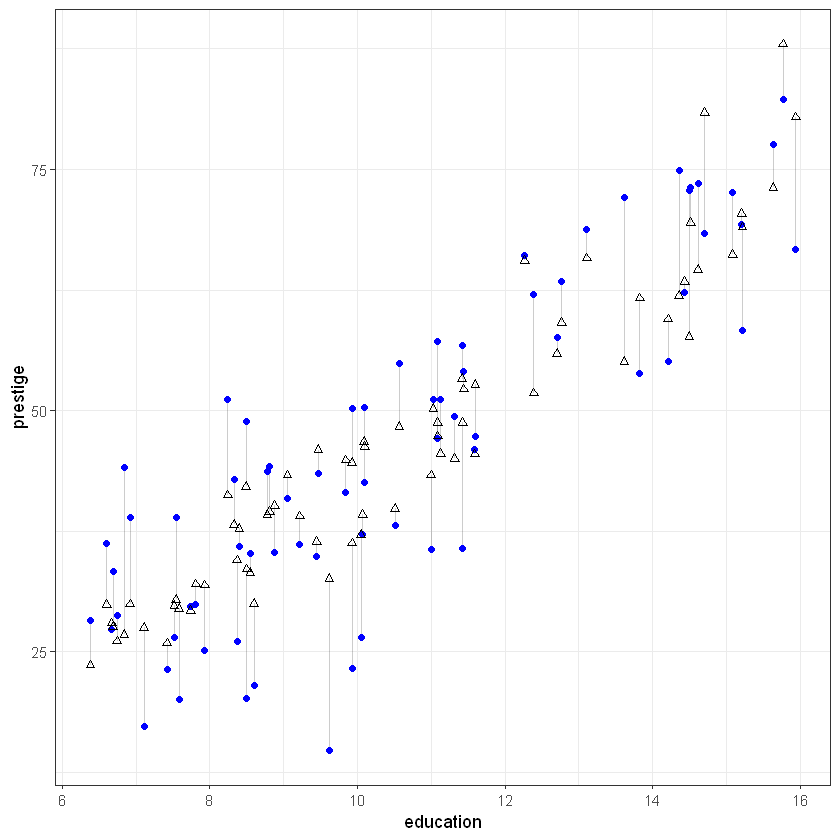

In [21]:
# prestige vs education
ggplot(tmp_data, aes(x = education, y = prestige)) +
  geom_segment(aes(xend = education, yend = predicted), alpha = .2) +
  geom_point(aes(), color = 'blue') +
  #scale_color_gradient2(low = "blue", mid = "white", high = "red") +
  #guides(color = FALSE) +
  geom_point(aes(y = predicted), shape = 2) +
  theme_bw()

Warning message:
"`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead."


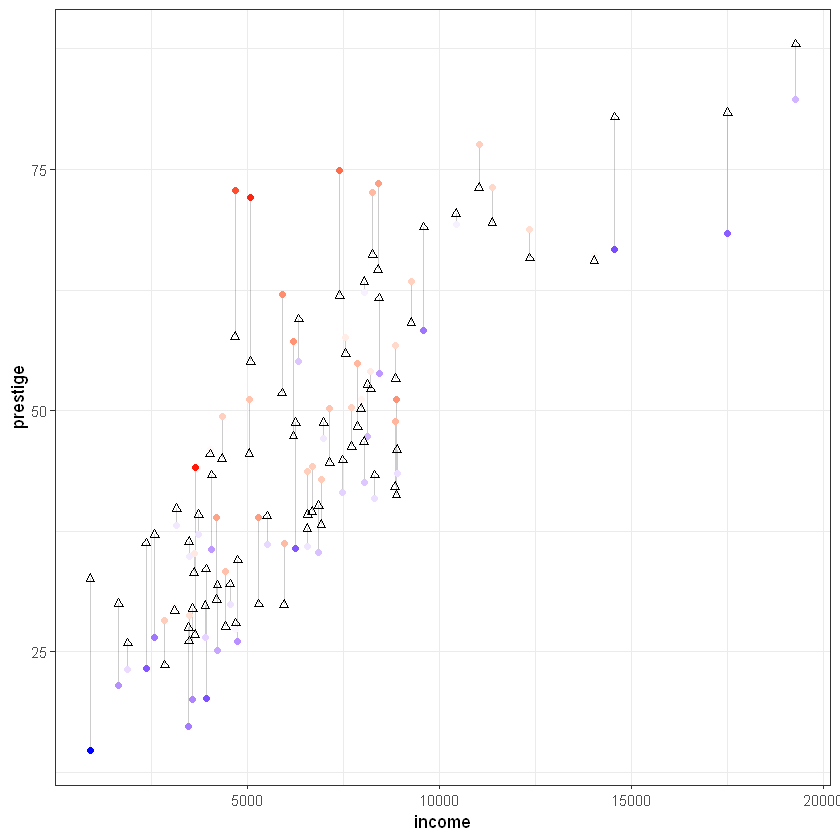

In [22]:
# prestige vs income
ggplot(tmp_data, aes(x = income, y = prestige)) +
  geom_segment(aes(xend = income, yend = predicted), alpha = .2) +
  geom_point(aes(color = residuals)) +
  scale_color_gradient2(low = "blue", mid = "white", high = "red") +
  guides(color = FALSE) +
  geom_point(aes(y = predicted), shape = 2) +
  theme_bw()


## Prediction on test data and accuracy

Здійснимо прогноз за допомогою функції `predict()`.

In [24]:
suppressMessages(library(dplyr))

test_predicted <- predict(lm_mod, test_data)

summary(test_predicted)
as.data.frame(sort(test_predicted) %>% head())

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  27.48   36.18   45.12   49.41   54.74   99.24 

,sort(test_predicted) %>% head()
,<dbl>
launderers,27.48046
babysitters,31.40819
slaughterers.1,32.38469
slaughterers.2,32.38469
bus.drivers,32.90378
electronic.workers,34.56204


`MSE` (`Mean Squared Error`) – середньоквадратичне відхилення; середнє значення квадратів відхилень прогнозованих даних від реальних.

In [25]:
mse <- mean((test_data$prestige - test_predicted)^2)
mse

[1] 68.60528

`MAPE`. `MAPE (Mean Absolute Percentage Error)` – середнє абсолютне відхилення прогнозованого показника від реального:

In [26]:
mape <- mean(abs(test_data$prestige - test_predicted)/test_data$prestige)
mape

[1] 0.1463553

Обчислимо метрики моделі за допомогою пакету `modelr` та функцій з нього:

In [27]:
suppressMessages(library(modelr))
data.frame(
  R2 = rsquare(lm_mod, data = train_data),
  MSE = mse(lm_mod, data = train_data),
  RMSE = rmse(lm_mod, data = train_data),
  MAE = mae(lm_mod, data = train_data),
  MAPE = mape(lm_mod, data = train_data)
)

data.frame(
  R2 = rsquare(lm_mod, data = test_data),
  MSE = mse(lm_mod, data = test_data),
  RMSE = rmse(lm_mod, data = test_data),
  MAE = mae(lm_mod, data = test_data),
  MAPE = mape(lm_mod, data = test_data)
)

R2,MSE,RMSE,MAE,MAPE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.7963876,57.70915,7.596654,6.158673,0.1656009


R2,MSE,RMSE,MAE,MAPE
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.7810138,68.60528,8.282831,6.27346,0.1463553


Mae - Mean Absolute Error. 
Rmse - Root mean squared error. Детальніше: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d.

### Перевірка на мультиколінераність

Зафіксуємо значення R^2 для моделі у деякій змінній:

In [28]:
r_sq = rsquare(lm_mod, data = test_data)
r_sq 

[1] 0.7810138

In [29]:
suppressMessages(library(car))

In [30]:
vif(lm_mod)

income education 
 1.720503  1.720503

Як видно вище тут мультиколінеарність відсутня.

Введемо в модель додатковий показник, що буде явно залежати від одного з факторів:

In [31]:
train_data <- train_data |> 
    mutate(income_2 = income / education)
head(train_data)

,education,income,women,prestige,census,type,income_2
,<dbl>,<int>,<dbl>,<dbl>,<int>,<fct>,<dbl>
elevator.operators,7.58,3582,30.08,20.1,6193,bc,472.5594
bookkeepers,11.32,4348,68.24,49.4,4131,wc,384.0989
telephone.operators,10.51,3161,96.14,38.1,4175,wc,300.7612
cooks,7.74,3116,52.00,29.7,6121,bc,402.5840
lawyers,15.77,19263,5.13,82.3,2343,prof,1221.4965
commercial.artists,11.09,6197,21.03,57.2,3314,prof,558.7917


In [32]:
lm_mod2 <- lm(formula = prestige ~ income + education + income_2, data = train_data)
summary(lm_mod2)
rsquare(lm_mod2, data = train_data)


Call:
lm(formula = prestige ~ income + education + income_2, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.7143  -5.5891  -0.1052   4.8973  19.8599 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -47.415903   9.703023  -4.887 6.70e-06 ***
income       -0.003839   0.001259  -3.049  0.00329 ** 
education     7.460147   0.888594   8.395 4.66e-12 ***
income_2      0.064989   0.014205   4.575 2.12e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.826 on 67 degrees of freedom
Multiple R-squared:  0.8449,	Adjusted R-squared:  0.8379 
F-statistic: 121.6 on 3 and 67 DF,  p-value: < 2.2e-16


[1] 0.8448559

In [33]:
vif(lm_mod2)

income education  income_2 
 28.60387   9.03815  17.04804

In [34]:
lm_mod2 <- lm(formula = prestige ~ education + income_2, data = train_data)
summary(lm_mod2)
rsquare(lm_mod2, data = train_data)


Call:
lm(formula = prestige ~ education + income_2, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-14.6486  -5.0597   0.3319   4.2756  18.2428 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -19.97418    3.83870  -5.203 1.97e-06 ***
education     4.90932    0.31704  15.485  < 2e-16 ***
income_2      0.02300    0.00369   6.234 3.31e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.231 on 68 degrees of freedom
Multiple R-squared:  0.8233,	Adjusted R-squared:  0.8181 
F-statistic: 158.5 on 2 and 68 DF,  p-value: < 2.2e-16


[1] 0.8233322

In [35]:
vif(lm_mod2)

education  income_2 
 1.025428  1.025428

In [32]:
#r_sq2 <- rsquare(lm_mod2, data = test_data)
#r_sq
#r_sq2

VIF-тест для моделі із корельованими змінними:

In [33]:
#vif(lm_mod2)

The best way is to exclude the biggest and rebuild model in this case. 

### Extending model

Додамо до моделі категоріальний параметр type. Переглянемо можливі варіанти значень:

In [36]:
unique(train_data$type)

[1] bc   wc   prof <NA>
Levels: bc prof wc

So, its a factor. with 3 values and missing data (NA).

Lets build new model with `type`:

In [38]:
lm_mod <- lm(formula = prestige ~ income + education + type, data = train_data)
summary(lm_mod)


Call:
lm(formula = prestige ~ income + education + type, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.3142  -3.6344  -0.3817   5.3981  13.0406 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.5646890  6.2763478   0.568 0.572084    
income      0.0014164  0.0003422   4.140 0.000105 ***
education   2.8686077  0.8030837   3.572 0.000685 ***
typeprof    9.2120726  4.6810471   1.968 0.053479 .  
typewc      0.2683361  3.0570578   0.088 0.930333    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.027 on 63 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.8369,	Adjusted R-squared:  0.8265 
F-statistic:  80.8 on 4 and 63 DF,  p-value: < 2.2e-16


З’явилися нові показники `typeprof` та `typewc`. Вони згенеровані автоматично як `dummy`-змінні функцією `lm()`. Якщо Ви хочете переглянути усі показники, що приймали участь у побудові моделі, то можна викликати $model:

In [39]:
lm_mod$model %>% head()

,prestige,income,education,type
,<dbl>,<int>,<dbl>,<fct>
elevator.operators,20.1,3582,7.58,bc
bookkeepers,49.4,4348,11.32,wc
telephone.operators,38.1,3161,10.51,wc
cooks,29.7,3116,7.74,bc
lawyers,82.3,19263,15.77,prof
commercial.artists,57.2,6197,11.09,prof


In [37]:
lm_mod$model

,prestige,income,education,type
,<dbl>,<int>,<dbl>,<fct>
civil.engineers,73.1,11377,14.52,prof
textile.weavers,33.3,4443,6.69,bc
tool.die.makers,42.5,8043,10.09,bc
insurance.agents,47.3,8131,11.60,wc
slaughterers.2,34.8,5134,7.64,bc
service.station.attendant,23.3,2370,9.93,bc
computer.operators,47.7,4330,11.36,wc
radio.tv.repairmen,37.2,5449,10.29,bc
electrical.linemen,40.9,8316,9.05,bc


---

## Model errors 

Переглянемо характеристики моделі:

In [40]:
lm_mod <- lm(formula = prestige ~ income + education + type, data = train_data)
summary(lm_mod)


Call:
lm(formula = prestige ~ income + education + type, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.3142  -3.6344  -0.3817   5.3981  13.0406 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.5646890  6.2763478   0.568 0.572084    
income      0.0014164  0.0003422   4.140 0.000105 ***
education   2.8686077  0.8030837   3.572 0.000685 ***
typeprof    9.2120726  4.6810471   1.968 0.053479 .  
typewc      0.2683361  3.0570578   0.088 0.930333    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.027 on 63 degrees of freedom
  (3 observations deleted due to missingness)
Multiple R-squared:  0.8369,	Adjusted R-squared:  0.8265 
F-statistic:  80.8 on 4 and 63 DF,  p-value: < 2.2e-16


Сформуємо розмітку для виведення графіків 4-х графіків одразу (2*2):

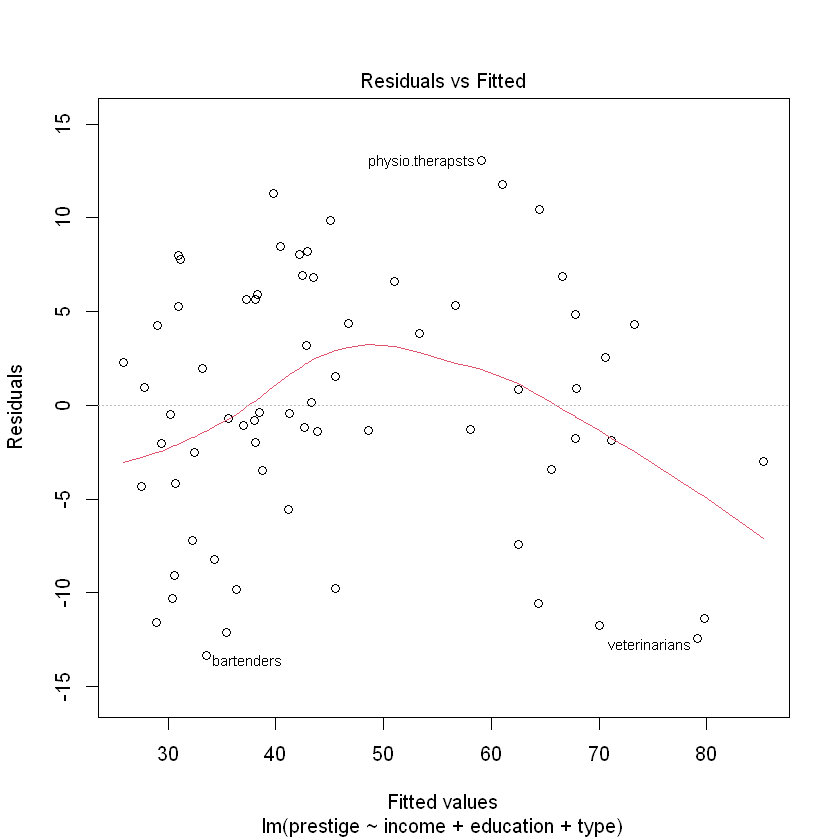

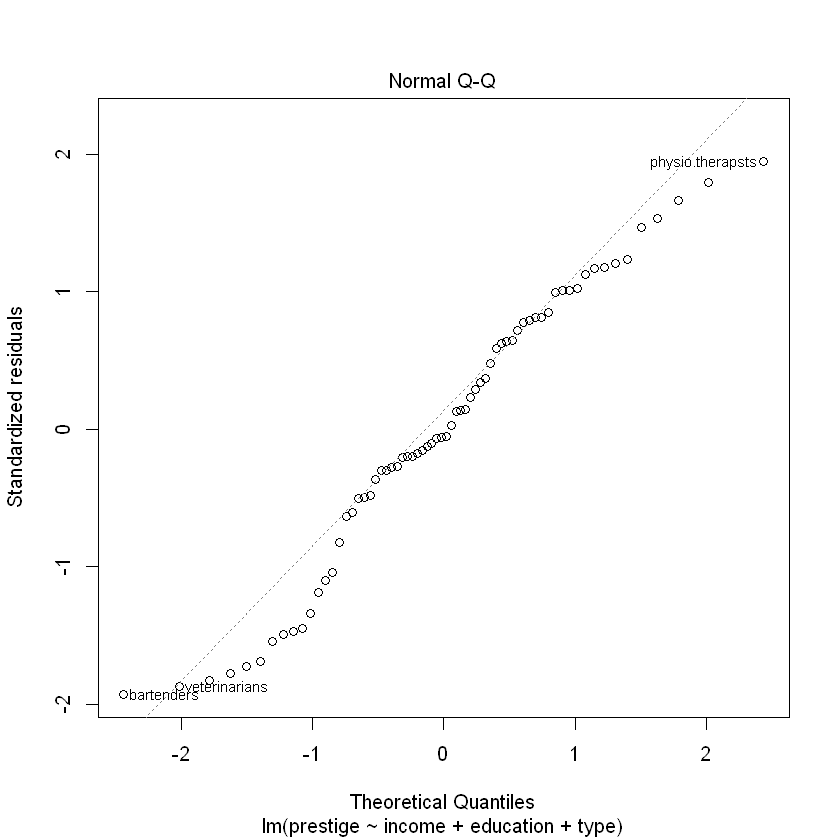

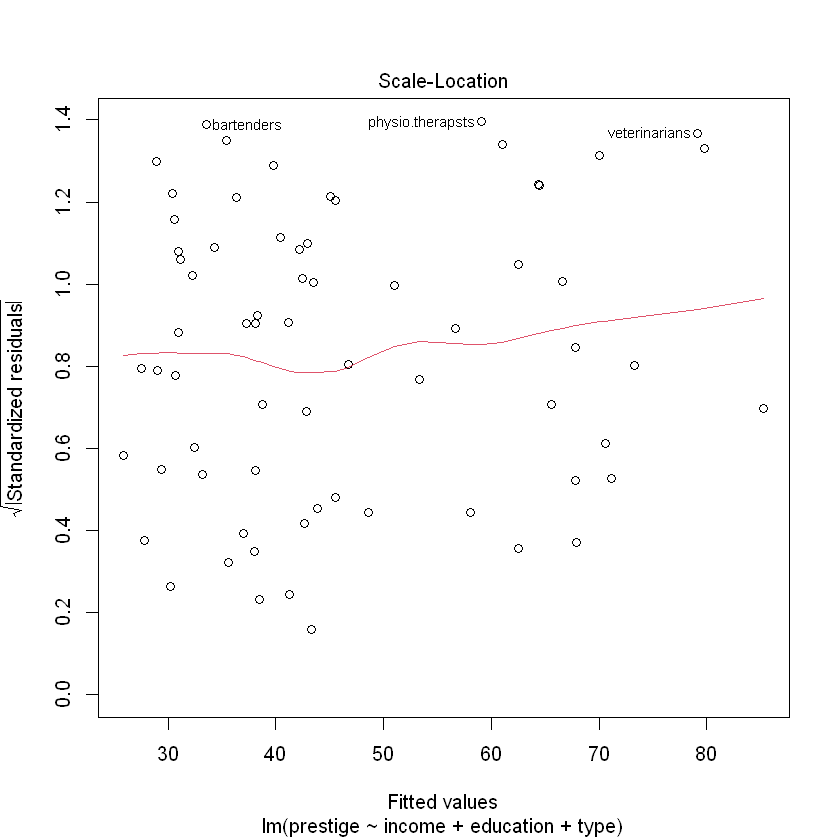

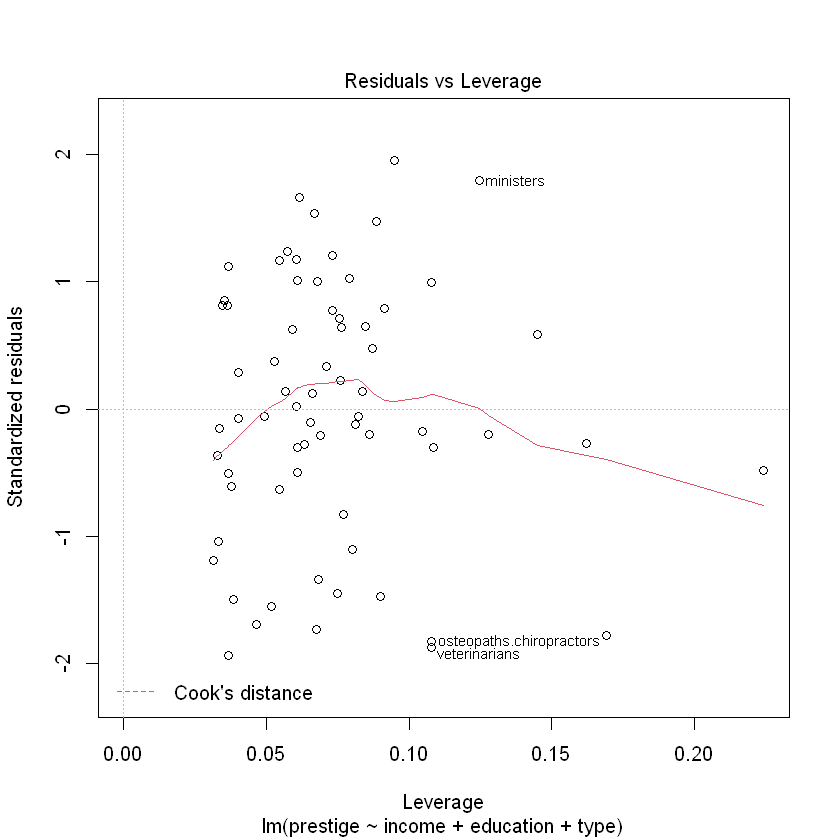

In [41]:
#par(mfrow=c(2,2))
plot(lm_mod)

На двох графіках зліва червона лінія показує середнє з відхилень. Якщо варіація похибок зростає разом із збільшенням значень прогнозу - це називається гетероскедастичніть. Прогнозування за таких умов буде давати спотворені результати. Переконаємося у відсутності гетероскедастичності перевіривши `p-value`:

In [42]:
suppressMessages(library(lmtest))
bptest(lm_mod)


	studentized Breusch-Pagan test

data:  lm_mod
BP = 9.9183, df = 4, p-value = 0.04183


`p-value > 0.05`, отже ми відхиляємо гіпотезу про те, що гетероскедастичність відсутня (залишки гомоскедастичні - мають однакову дисперсію).

`Normal QQ`-графік дозволяє перевірити чи похибки розподілені за нормальним законом розподілу. Ідеальний варіант коли вони розміщені чітко по діагональній лінії.

На останньому графіку показується як кожне значення впливає на регресію. У статистиці відстань Кука є загальноприйнятою оцінкою впливу спостереження під час застосування методу найменших квадратів у регресійному аналізі.На практиці, при застосуванні методу найменших квадратів, відстань Кука може використовуватися для наступних цілей: визначити впливові спостереження даних, які потрібно перевірити на валідність; визначення областей простору, у яких непогано було б отримати більше результатів спостереження. Джерело: Detection of Influential Observation in Linear Regression / R. Dennis Cook (https://www.jstor.org/stable/1268249?origin=crossref&seq=1)

Повернемо розмітку для 1-го графіка у вікні RStudio:

In [49]:
par(mfrow=c(1,1))

Переглянемо розподіл похибок:

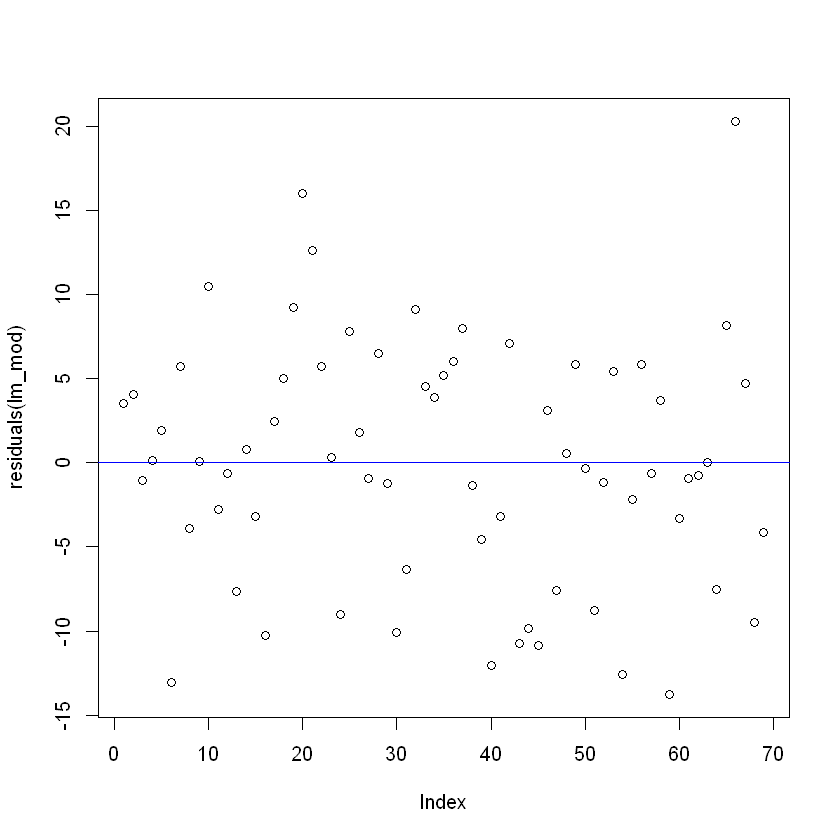

In [50]:
plot(residuals(lm_mod)) 
abline(a=0,b=0,col='blue')

Візуальних закономірностей у похибках немає. Схоже, що вони мають випадковий характер.

---

## Features selection

Ручний відбір параметрів моделі має ряд недоліків, що пов’язані із якістю моделі та затратами часу на її побудову. Вивчимо окремі алгоритми автоматизованого відбору параметрів у модель.

### BestSubsets method

Метод `BestSubsets` також відомий як `all possible regressions`. Цей метод відповідно до назв будує всі можливі варіанти моделей на незалежних змінних. Кількість моделей становить $2^p$, де $p$ - кількість неазелжних змінних, так для 10 вхідних параметрів буде побудовано $2^10 =1024$ моделей.

In [7]:
library(leaps)
best_subsets_mod <- regsubsets(prestige ~ income + education + type + women, data = train_data)

Розгялнемо відібрані параметри моделі BestSubsets. По осі `Y` розміщені значення `BIC`, який обраний як якісний показник регресії, по `X` - параметри моделі:

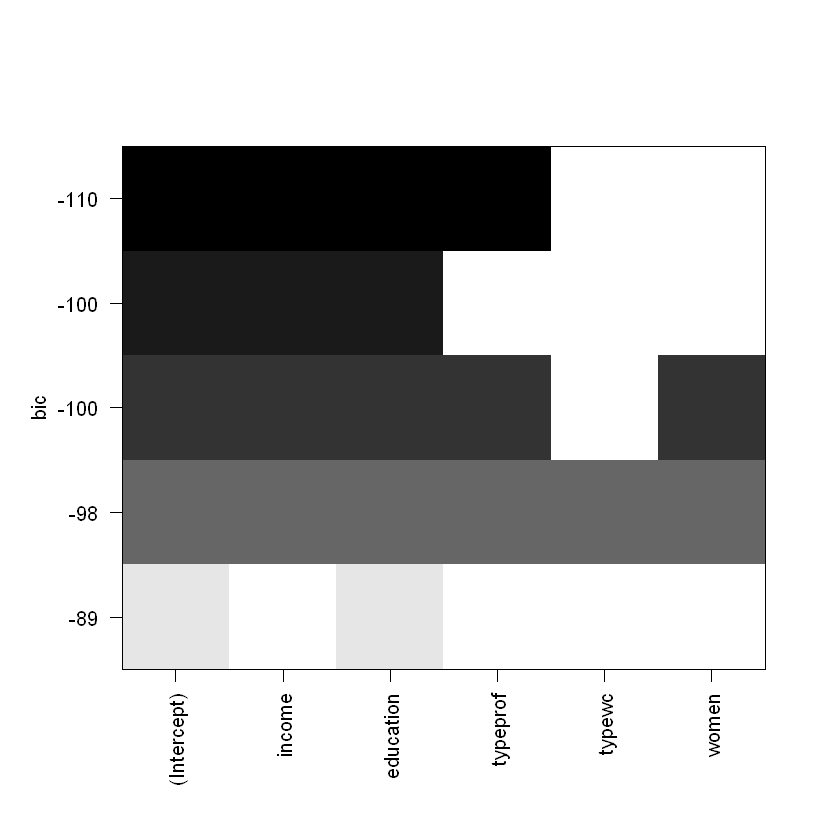

In [8]:
plot(best_subsets_mod)

Найтемніша лінія вказує на найкращу модель.

Перебудуємо модель для усіх можливих варіантів комбінацій параметрів:

In [9]:
best_subsets_mod <- regsubsets(prestige ~ income + education + type + women, data = train_data)

Також можемо обрати кращу модель окремо за критеріями, наприклад скоригований $R^2$:

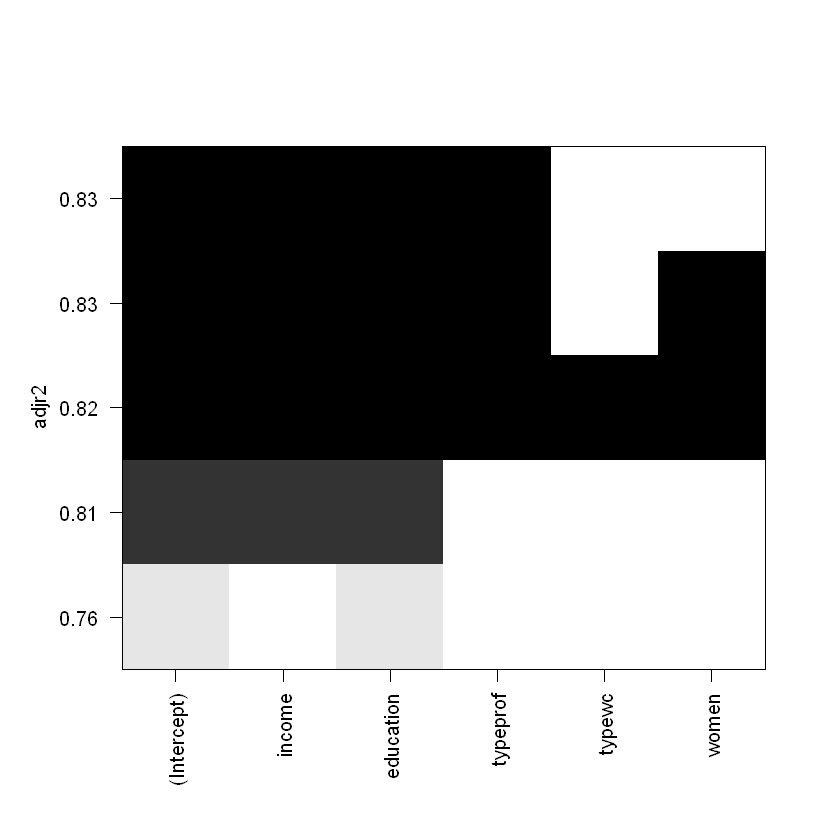

In [10]:
plot(best_subsets_mod, scale = "adjr2")

Моделі з найвищим $R^2$ обираються у такому випадку за цим критерієм, проте не варто забувати про появу мультиколінеарності.

In [11]:
results <- summary(best_subsets_mod)
round(results$adjr2, 4)

[1] 0.7566 0.8132 0.8292 0.8265 0.8238

In [12]:
model_index <- which.max(results$adjr2)
t <- results$which[model_index, ]
as.data.frame(t)

,t
,<lgl>
(Intercept),TRUE
income,TRUE
education,TRUE
typeprof,TRUE
typewc,FALSE
women,FALSE


So, the best regression by Adjusted R-Squared is 

```a0 + a1*income + a2*typeprof + a3*income:typeprof + a4*education:women + a5*income:education:typeprof + a6*income:typeprof:women + a7*income:typewc:women + a8*income:education:typewc:women```

---

### Stepwise method

Stepwise - метод, що перебирає можливі варіанти та повертає найкращу модель з найнижчим показником AIC. Перебір моделі може бути з виключенням або з включенням показників у модель - у обох напрямках.

Для початку очистимо дані, що мають пропуски у полі type (також ці дані можна заповнити).

In [15]:
library(dplyr)
nrow(train_data)
train_data <- train_data[!is.na(train_data$type), ]
nrow(train_data)
#train_data <- train_data |> select(-income_2)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




[1] 68

[1] 68

Найпростіша модель з одним параметром (першим по списку) матиме вигляд:

In [17]:
start_mod <- lm(prestige ~ 1, data = train_data)

Модель з усіма параметрами:

In [18]:
end_mod <- lm(prestige ~ ., data = train_data)

Запустимо алгоритм функцією `step()`:

In [19]:
stepwise_mod <- step(start_mod, 
                     # set minimum and maximum parameters
                     scope = list(lower = start_mod, upper = end_mod),
                     # direction of model building
                     direction = "both", trace = 1, steps = 1000)
                     # c("both", "backward", "forward") - possible directions

Start:  AIC=385.27
prestige ~ 1

            Df Sum of Sq     RSS    AIC
+ education  1   14497.5  4571.5 290.15
+ type       2   13514.0  5555.0 305.40
+ income     1   10681.4  8387.6 331.42
+ census     1    8004.5 11064.5 350.26
<none>                   19069.1 385.27
+ women      1     472.4 18596.7 385.56

Step:  AIC=290.15
prestige ~ education

            Df Sum of Sq     RSS    AIC
+ income     1    1115.8  3455.7 273.12
+ type       2     614.5  3957.0 284.33
+ women      1     495.3  4076.2 284.35
+ census     1     303.7  4267.8 287.48
<none>                    4571.5 290.15
- education  1   14497.5 19069.1 385.27

Step:  AIC=273.12
prestige ~ education + income

            Df Sum of Sq    RSS    AIC
+ type       2     344.9 3110.8 269.97
<none>                   3455.7 273.12
+ census     1      13.4 3442.3 274.86
+ women      1       6.5 3449.3 275.00
- income     1    1115.8 4571.5 290.15
- education  1    4931.9 8387.6 331.42

Step:  AIC=269.97
prestige ~ education + i

In [20]:
# lets see the summary
summary(stepwise_mod)


Call:
lm(formula = prestige ~ education + income + type, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.3142  -3.6344  -0.3817   5.3981  13.0406 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.5646890  6.2763478   0.568 0.572084    
education   2.8686077  0.8030837   3.572 0.000685 ***
income      0.0014164  0.0003422   4.140 0.000105 ***
typeprof    9.2120726  4.6810471   1.968 0.053479 .  
typewc      0.2683361  3.0570578   0.088 0.930333    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.027 on 63 degrees of freedom
Multiple R-squared:  0.8369,	Adjusted R-squared:  0.8265 
F-statistic:  80.8 on 4 and 63 DF,  p-value: < 2.2e-16


> З підсумків моделі видно, що детермінація зросла, тобто модель стала описувати явище ще краще.

---